In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [11]:
# 定义 CNN 模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # 展平
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
# 加载 MNIST 数据集的方法
def load_mnist_data(data_path="./data"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    # 检查 MNIST 数据是否存在
    train_exists = os.path.exists(os.path.join(data_path, "MNIST/raw/train-images-idx3-ubyte"))
    test_exists = os.path.exists(os.path.join(data_path, "MNIST/raw/t10k-images-idx3-ubyte"))

    if train_exists and test_exists:
        print("✅ MNIST 数据集已存在，跳过下载。")
    else:
        print("⬇️ 正在下载 MNIST 数据集...")

    # 加载数据集
    train_data = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root=data_path, train=False, transform=transform, download=True)

    # 显示部分示例图片
    visualize_mnist_samples(train_data)

    return train_data, test_data

# 显示数据集示例图片
def visualize_mnist_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 1.2, 1.5))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap="gray")
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.show()

In [13]:
# 创建客户端数据集，分配不同的数据量
def split_data_unevenly(dataset, num_clients):
    total_size = len(dataset)
    client_sizes = np.random.randint(low=5000, high=15000, size=num_clients)  # 生成不同大小的数据集
    client_sizes = (client_sizes / client_sizes.sum() * total_size).astype(int)  # 调整比例，保证总数不变

    client_datasets = []
    start_idx = 0
    for size in client_sizes:
        end_idx = min(start_idx + size, total_size)
        client_datasets.append(torch.utils.data.Subset(dataset, list(range(start_idx, end_idx))))
        start_idx = end_idx  # 更新起始索引

    print(f"📊 客户端数据分布: {client_sizes}")
    return client_datasets

In [14]:
# 本地训练函数
def local_train(model, train_loader, epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    return model.state_dict()

In [15]:
# 联邦平均聚合函数 (考虑不同数据量的加权平均)
def fed_avg(global_model, client_state_dicts, client_sizes):
    global_dict = global_model.state_dict()
    total_data = sum(client_sizes)
    for key in global_dict.keys():
        global_dict[key] = sum(client_state[key] * (size / total_data) for client_state, size in zip(client_state_dicts, client_sizes))
    global_model.load_state_dict(global_dict)
    return global_model

In [16]:
# 评估模型
def evaluate(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct, total, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    accuracy = correct / total * 100
    return total_loss / len(test_loader), accuracy


In [17]:
def main():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

    # 预处理
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])


    # 加载 MNIST 数据集
    train_data, test_data = load_mnist_data()

    # 分割训练数据到多个客户端
    num_clients = 5  # 客户端数量
    client_datasets = split_data_unevenly(train_data, num_clients)  # 分割不同大小的数据集
    client_sizes = [len(dataset) for dataset in client_datasets]

    # 创建数据加载器
    client_loaders = [data.DataLoader(client_data, batch_size=32, shuffle=True) for client_data in client_datasets]
    test_loader = data.DataLoader(test_data, batch_size=32, shuffle=False)

    print("\n📌 MNIST 数据集加载完成！")

    # 初始化全局模型
    global_model = CNNModel()

    rounds = 5  # 联邦学习轮数
    for r in range(rounds):
        print(f"\n🔄 第 {r+1} 轮聚合")
        client_state_dicts = []

        # 客户端本地训练
        for i, client_loader in enumerate(client_loaders):
            local_model = CNNModel()
            local_model.load_state_dict(global_model.state_dict())  # 复制全局模型参数
            local_state = local_train(local_model, client_loader, epochs=1, lr=0.01)  # 训练 1 轮
            client_state_dicts.append(local_state)

            # 计算客户端模型参数平均值（用于打印）
            param_mean = {name: param.mean().item() for name, param in local_model.named_parameters()}

            print(f"  ✅ 客户端 {i+1} 训练完成 | 样本数量: {client_sizes[i]}")
            print(f"    📌 客户端 {i+1} 模型参数均值: {param_mean}")

        # 聚合模型参数（考虑不同数据量的加权平均）
        global_model = fed_avg(global_model, client_state_dicts, client_sizes)

        # 评估模型
        loss, accuracy = evaluate(global_model, test_loader)
        print(f"📊 测试集损失: {loss:.4f} | 测试集准确率: {accuracy:.2f}%")

        # 计算全局模型参数平均值
        global_param_mean = {name: param.mean().item() for name, param in global_model.named_parameters()}
        print(f"🔄 轮 {r+1} 结束后，全局模型参数均值: {global_param_mean}")

    # 输出最终全局模型参数
    print("\n📝 最终全局模型参数：")
    for name, param in global_model.named_parameters():
        print(name, param.data)

    # 输出最终模型的性能
    final_loss, final_accuracy = evaluate(global_model, test_loader)
    print(f"\n🎯 最终模型测试集损失: {final_loss:.4f}")
    print(f"🎯 最终模型测试集准确率: {final_accuracy:.2f}%")

✅ MNIST 数据集已存在，跳过下载。


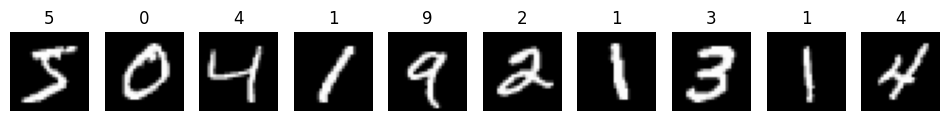

📊 客户端数据分布: [ 8446 16216  9027 10769 15539]

📌 MNIST 数据集加载完成！

🔄 第 1 轮聚合
  ✅ 客户端 1 训练完成 | 样本数量: 8446
    📌 客户端 1 模型参数均值: {'conv1.weight': 0.027271274477243423, 'conv1.bias': -0.0784945860505104, 'conv2.weight': 0.0036779430229216814, 'conv2.bias': 0.01150550227612257, 'fc1.weight': 0.0003461642481852323, 'fc1.bias': 0.002291906625032425, 'fc2.weight': -0.0006528877420350909, 'fc2.bias': 0.008084185421466827}
  ✅ 客户端 2 训练完成 | 样本数量: 16216
    📌 客户端 2 模型参数均值: {'conv1.weight': 0.03547171503305435, 'conv1.bias': -0.07423212379217148, 'conv2.weight': 0.0032907009590417147, 'conv2.bias': 0.010470095090568066, 'fc1.weight': 0.00032693444518372416, 'fc1.bias': 0.0022915906738489866, 'fc2.weight': -0.0006528873927891254, 'fc2.bias': 0.008084185421466827}
  ✅ 客户端 3 训练完成 | 样本数量: 9027
    📌 客户端 3 模型参数均值: {'conv1.weight': 0.02795880287885666, 'conv1.bias': -0.07777148485183716, 'conv2.weight': 0.0036385436542332172, 'conv2.bias': 0.011688386090099812, 'fc1.weight': 0.0003607958205975592, 'fc1.bias': 

In [18]:
if __name__ == "__main__":
    main()